In [1]:
%%capture
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import math

import seaborn as sns
import matplotlib.pyplot as plt
import patchworklib as pw

from py_helper_functions import *

from datetime import datetime

from patsy.highlevel import dmatrices

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.impute import SimpleImputer
from sklearn.inspection import permutation_importance
from sklearn.inspection import PartialDependenceDisplay
from sklearn.inspection import partial_dependence
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import RepeatedKFold
from sklearn.linear_model import Lasso
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import ElasticNet

In [122]:
def get_cleaned_data(src=None) -> pd.DataFrame:
    '''
    This function takes a path to a csv file, cleans it and returns the cleaned dataframe
    :param src: path to file
    :return: dataframe with cleaned data
    '''
    if src:
        df = pd.read_csv(src)
    else:
        urls = ['https://raw.githubusercontent.com/viethngn/Data_Analysis_3_ECBS5171/main/assignment2/listings_1.csv', 'https://raw.githubusercontent.com/viethngn/Data_Analysis_3_ECBS5171/main/assignment2/listings_2.csv']
        dfs = []
        for url in urls:
            u_df = pd.read_csv(url)
            dfs.append(u_df)
        df = pd.concat(dfs, ignore_index=True)
    
    # Filter the data for:
    #
    # new apartment not on market so no need to care about reviews
    working_sample = df[['id','name','host_id','host_name','host_since','host_is_superhost','host_total_listings_count','host_has_profile_pic','host_identity_verified','neighbourhood_cleansed','property_type','room_type','accommodates','bathrooms_text','bedrooms','beds','amenities','price','minimum_nights','maximum_nights','number_of_reviews','review_scores_value','instant_bookable', 'license']
                        ][(df['price'].notna()) 
                        & (df['beds'].notna())
                        & (df['host_is_superhost'].notna())
                        & (df['host_since'].notna())
                        & (df['bathrooms_text'].notna())
                        & (df['room_type'] != 'Hotel room')
                        & (df['accommodates'] <= 6) & (df['accommodates'] >= 2)
                        & (df['neighbourhood_cleansed'].isin(['Palermo', 'Catania', 'Gravina di Catania', 'San Gregorio di Catania', 'Militello in Val di Catania', 'Messina', 'Taormina', 'Realmonte', 'Agrigento', 'Siracusa', 'Cefal', 'Monreale', 'Ragusa', 'Modica']))]
    
    # fill NA data for reviews with 0s
    working_sample['review_scores_value'].fillna(0, inplace=True)
    
    # fill NA data for bedrooms with 1s
    working_sample['bedrooms'].fillna(1, inplace=True)
    
    # fill NA data for license with NAN
    working_sample['license'].fillna('NAN', inplace=True)
    
    # add boolean variables from text columns
    working_sample['d_host_is_superhost'] = working_sample['host_is_superhost'].apply(lambda x: 1 if x == 't' else 0)
    working_sample['d_host_has_profile_pic'] = working_sample['host_has_profile_pic'].apply(lambda x: 1 if x == 't' else 0)
    working_sample['d_host_identity_verified'] = working_sample['host_identity_verified'].apply(lambda x: 1 if x == 't' else 0)
    working_sample['d_instant_bookable'] = working_sample['instant_bookable'].apply(lambda x: 1 if x == 't' else 0)
    working_sample['d_has_license'] = working_sample['license'].apply(lambda x: 1 if x != 'NAN' else 0)
    
    # calculate host time
    working_sample['n_host_since'] = working_sample['host_since'].apply(lambda x: (pd.Timestamp('2023-03-31') - pd.Timestamp(x)).days)
    
    # convert price to numerical
    working_sample['price'] = working_sample['price'].apply(lambda x: float(x.replace('$', '').replace(',', '')))
    
    # filter for price < 
    working_sample = working_sample[(working_sample['price'] <= 400)]
    
    # add numerical variable for number of bath
    working_sample['n_bathrooms'] = working_sample['bathrooms_text'].apply(lambda x: 0.5 if 'half-bath' in x.lower() else float(x.lower().split()[0]))
    
    # clean the property type and room type
    working_sample['property_type'] = working_sample['property_type'].apply(lambda x: x.lower().replace('entire ', '').replace('private room ', '').replace('shared room ', '').replace('room in ', '').replace('in ', ''))
    working_sample['room_type'] = working_sample['room_type'].apply(lambda x: x.lower())
    
    # add amenities columns
    working_sample['d_entertainment'] = working_sample['amenities'].apply(lambda x: 1 if 'tv' in x.lower() or 'game' in x.lower() or 'roku' in x.lower() or 'disney' in x.lower() or 'netflix' in x.lower() or 'nintendo' in x.lower() or'chromecast' in x.lower() or 'alexa' in x.lower() or 'sound' in x.lower() else 0)
    working_sample['d_wifi'] = working_sample['amenities'].apply(lambda x: 1 if 'wifi' in x.lower() else 0)
    working_sample['d_kitchenware'] = working_sample['amenities'].apply(lambda x: 1 if 'fridge' in x.lower() or 'freezer' in x.lower() or 'stove' in x.lower() or 'coffee' in x.lower() or 'oven' in x.lower() or 'blender' in x.lower() or 'grill' in x.lower() or 'dishwasher' in x.lower() else 0)
    working_sample['d_washer'] = working_sample['amenities'].apply(lambda x: 1 if ('washer' in x.lower() or 'dryer' in x.lower() or 'drying' in x.lower()) else 0)
    working_sample['d_sauna_hot_tub'] = working_sample['amenities'].apply(lambda x: 1 if 'sauna' in x.lower() or 'tub' in x.lower() else 0)
    working_sample['d_pool'] = working_sample['amenities'].apply(lambda x: 1 if ' pool' in x.lower() or 'Pool' in x else 0)
    working_sample['d_aircon'] = working_sample['amenities'].apply(lambda x: 1 if 'air con' in x.lower() else 0)
    working_sample['d_heating'] = working_sample['amenities'].apply(lambda x: 1 if 'heating' in x.lower() else 0)
    working_sample['d_scenic_view_access'] = working_sample['amenities'].apply(lambda x: 1 if 'view' in x.lower() or 'access' in x.lower() else 0)
    working_sample['d_parking'] = working_sample['amenities'].apply(lambda x: 1 if 'parking' in x.lower() or 'carport' in x.lower() else 0)
    working_sample['d_pets_allowed'] = working_sample['amenities'].apply(lambda x: 1 if 'pets allowed' in x.lower() else 0)
    working_sample['d_patio_balcony'] = working_sample['amenities'].apply(lambda x: 1 if 'patio' in x.lower() or 'balcony' in x.lower() else 0)
    working_sample['d_bodyshower'] = working_sample['amenities'].apply(lambda x: 1 if 'shampoo' in x.lower() or 'conditioner' in x.lower() or 'soap' in x.lower() or 'gel' in x.lower() else 0)
    
    # rename numerical and categorical columns to have prefix
    working_sample.rename(columns={
        'host_total_listings_count': 'n_host_total_listings_count',
        'accommodates': 'n_accommodates',
        'bedrooms': 'n_bedrooms',
        'beds': 'n_beds',
        'minimum_nights': 'n_minimum_nights',
        'maximum_nights': 'n_maximum_nights',
        'neighbourhood_cleansed': 'f_neighbourhood_cleansed',
        'property_type': 'f_property_type',
        'room_type': 'f_room_type',
        'review_scores_value': 'n_review_scores_value',
        'number_of_reviews': 'n_number_of_reviews'
    }, inplace=True)
    
    del df
    if not src:
        del dfs[0]
        del dfs[1]
        
    return working_sample

In [124]:
work_df = get_cleaned_data('listings.csv')
# work_df = get_cleaned_data()
work_df.shape;

(16240, 44)

In [8]:
categorical_columns = [col for col in work_df.columns if col.startswith("f_")]
numerical_columns = [col for col in work_df.columns if col.startswith("n_") or col.startswith("d_")]

In [9]:
# build interaction terms
# interactions = ['f_property_type*f_room_type',
#                 'n_accommodates*f_property_type',
#                 'n_accommodates*f_room_type',
#                 'f_property_type*f_neighbourhood_cleansed',
#                 'f_room_type*f_neighbourhood_cleansed',
#                 'n_accommodates*f_neighbourhood_cleansed'
#                 ]
interactions = []
for i in categorical_columns + numerical_columns:
    for k in categorical_columns + numerical_columns:
        if i == k:
            continue
        else:
            interactions.append(i + '*' + k)

In [43]:
# ols get train test split
def get_ols_train_test_split(data, lasso=False):
    if lasso:
        y_, ols_df = dmatrices('price~' + '+'.join(numerical_columns) + '+' + '+'.join(categorical_columns) + '+' + '+'.join(interactions), data, return_type="dataframe")
    else:
        y_, ols_df = dmatrices('price~' + '+'.join(numerical_columns) + '+' + '+'.join(categorical_columns), data, return_type="dataframe")
    ols_terms_list = ols_df.design_info.column_names
    ols_df['price'] = y_
    ols_data_train, ols_data_holdout = train_test_split(ols_df, train_size=0.7, random_state=42)
    return ols_data_train, ols_data_holdout, ols_terms_list

In [11]:
data_train, data_holdout = train_test_split(work_df, train_size=0.7, random_state=42)
data_train.shape, data_holdout.shape

((11370, 43), (4873, 43))

Simple OLS

In [50]:
ols_data_train, ols_data_holdout, ols_terms_list = get_ols_train_test_split(work_df)

start_time = datetime.now()
ols_model = LinearRegression().fit(ols_data_train[ols_terms_list], ols_data_train['price'])
ols_time = datetime.now() - start_time
ols_model

LinearRegression()

In [51]:
ols_rmse = mean_squared_error(ols_model.predict(ols_data_train.drop(columns=['price'])), ols_data_train['price'], squared=False)
ols_rmse

44.39835625519609

LASSO

In [52]:
# LASSO for OLS
def get_lasso_matrices(data):
    y_ = data['price']
    X_ = data[lasso_terms_list]
    scaler = StandardScaler()
    X_ = scaler.fit_transform(X_)
    return y_, X_

In [45]:
%%time
# get lasso data split
lasso_data_train, lasso_data_holdout, lasso_terms_list = get_ols_train_test_split(work_df, lasso=True)

# define model
lasso_model = ElasticNet(l1_ratio = 1, fit_intercept = True)

# define cv search
lasso_search = GridSearchCV(
    lasso_model,
    {"alpha":[i/100 for i in range(10, 55, 5)]},
    cv=5,
    scoring="neg_root_mean_squared_error",
    verbose=3,
)

# perform the search
y, X = get_lasso_matrices(lasso_data_train)

start_time = datetime.now()
lasso_results = lasso_search.fit(X, y)
lasso_time = datetime.now() - start_time

Fitting 5 folds for each of 11 candidates, totalling 55 fits
[CV 1/5] END ......................alpha=0.05;, score=-46.554 total time=  14.4s
[CV 2/5] END ......................alpha=0.05;, score=-43.829 total time=  19.5s
[CV 3/5] END ......................alpha=0.05;, score=-45.206 total time=  15.7s
[CV 4/5] END ......................alpha=0.05;, score=-45.545 total time=  14.4s
[CV 5/5] END ......................alpha=0.05;, score=-45.539 total time=  18.5s
[CV 1/5] END .......................alpha=0.1;, score=-45.866 total time=   8.8s
[CV 2/5] END .......................alpha=0.1;, score=-42.476 total time=   9.3s
[CV 3/5] END .......................alpha=0.1;, score=-44.461 total time=  10.0s
[CV 4/5] END .......................alpha=0.1;, score=-44.807 total time=  12.0s
[CV 5/5] END .......................alpha=0.1;, score=-44.859 total time=  14.2s
[CV 1/5] END ......................alpha=0.15;, score=-45.409 total time=   9.1s
[CV 2/5] END ......................alpha=0.15;, 

In [46]:
lasso_results.best_estimator_

ElasticNet(alpha=0.25, l1_ratio=1)

In [47]:
lasso_results.best_score_

-43.929369640355546

In [18]:
df_lasso_results = pd.DataFrame(lasso_results.cv_results_)[['param_alpha', 'rank_test_score', 'mean_test_score']]
df_lasso_results

,param_alpha,rank_test_score,mean_test_score
0,0.05,11,-45.334646
1,0.1,10,-44.493715
2,0.15,9,-44.142866
3,0.2,4,-43.985576
4,0.25,1,-43.929370
5,0.3,2,-43.938066
6,0.35,3,-43.959676
7,0.4,5,-43.991922
8,0.45,6,-44.030710
9,0.5,7,-44.071708


In [19]:
df_ols_var_coefs = pd.DataFrame(
    lasso_results.best_estimator_.coef_.tolist(),
    index=lasso_terms_list,
    columns=["lasso_coefficient"],
).assign(lasso_coefficient=lambda x: x.lasso_coefficient.round(3)).loc[
    lambda x: x.lasso_coefficient != 0
]
df_ols_var_coefs['abs_lasso_coefficient'] = df_ols_var_coefs["lasso_coefficient"].apply(lambda x: x if x >= 0 else x * -1)
df_ols_var_coefs.sort_values(by="abs_lasso_coefficient", ascending=False).iloc[:30]

,lasso_coefficient,abs_lasso_coefficient
n_accommodates:n_bedrooms,6.331,6.331
f_room_type[T.private room]:n_bathrooms,-6.140,6.140
d_wifi:d_pool,4.303,4.303
n_bathrooms:d_pool,4.081,4.081
n_accommodates:n_review_scores_value,-4.055,4.055
n_accommodates:n_bathrooms,3.825,3.825
f_property_type[T.bed and breakfast]:d_instant_bookable,3.603,3.603
f_property_type[T.resort]:n_accommodates,3.441,3.441
n_bathrooms:d_wifi,3.074,3.074
n_bedrooms:n_bathrooms,3.005,3.005


Random Forest

In [20]:
# building preprocessing for pipeline
categorical_encoder = OneHotEncoder(handle_unknown="ignore")

preprocessing = ColumnTransformer(
    [
        ("cat", categorical_encoder, categorical_columns),
        ("num", "passthrough", numerical_columns),
    ]
)

In [21]:
tune_grid = {"max_features": [8, 10, 12], "min_samples_leaf": [5, 10, 15]}

rfr = RandomForestRegressor(random_state = 42)

rf_random = GridSearchCV(
    rfr,
    tune_grid,
    cv=5,
    scoring="neg_root_mean_squared_error",
    verbose=3,
)

In [22]:
rf_pipe = Pipeline(
    [("preprocess", preprocessing), ("regressor", rf_random)], verbose=True
)

In [23]:
%%time
start_time = datetime.now()
rf_model = rf_pipe.fit(data_train[numerical_columns + categorical_columns], data_train['price'])
rf_time = datetime.now() - start_time
rf_model

[Pipeline] ........ (step 1 of 2) Processing preprocess, total=   0.0s
Fitting 5 folds for each of 9 candidates, totalling 45 fits
[CV 1/5] END max_features=8, min_samples_leaf=5;, score=-45.543 total time=   0.6s
[CV 2/5] END max_features=8, min_samples_leaf=5;, score=-42.580 total time=   0.6s
[CV 3/5] END max_features=8, min_samples_leaf=5;, score=-43.440 total time=   0.6s
[CV 4/5] END max_features=8, min_samples_leaf=5;, score=-44.296 total time=   0.5s
[CV 5/5] END max_features=8, min_samples_leaf=5;, score=-45.354 total time=   0.5s
[CV 1/5] END max_features=8, min_samples_leaf=10;, score=-46.238 total time=   0.4s
[CV 2/5] END max_features=8, min_samples_leaf=10;, score=-43.507 total time=   0.4s
[CV 3/5] END max_features=8, min_samples_leaf=10;, score=-44.449 total time=   0.4s
[CV 4/5] END max_features=8, min_samples_leaf=10;, score=-45.222 total time=   0.4s
[CV 5/5] END max_features=8, min_samples_leaf=10;, score=-46.430 total time=   0.4s
[CV 1/5] END max_features=8, min_s

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['f_neighbourhood_cleansed',
                                                   'f_property_type',
                                                   'f_room_type']),
                                                 ('num', 'passthrough',
                                                  ['n_accommodates',
                                                   'n_bedrooms', 'n_beds',
                                                   'n_minimum_nights',
                                                   'n_maximum_nights',
                                                   'n_number_of_reviews',
                                                   'n_review_scores_value',
                                                   'd_host_is_superhost',
                                                   'd_host_has_p...
                                                   'd_sauna_hot_tub', 'd_pool',
                                                   'd_aircon', 'd_heating',
                                                   'd_scenic_view_access',
                                                   'd_parking',
                                                   'd_pets_allowed',
                                                   'd_patio_balcony',
                                                   'd_bodyshower'])])),
                ('regressor',
                 GridSearchCV(cv=5,
                              estimator=RandomForestRegressor(random_state=42),
                              param_grid={'max_features': [8, 10, 12],
                                          'min_samples_leaf': [5, 10, 15]},
                              scoring='neg_root_mean_squared_error',
                              verbose=3))],
         verbose=True)

In [24]:
df_rf_model_cv_results = pd.DataFrame(rf_random.cv_results_)[[
    'param_max_features', 'param_min_samples_leaf', 'mean_test_score']]
df_rf_model_cv_results.columns = ['max features', 'min node size', 'RMSE']
df_rf_model_cv_results.pivot(
    index = 'max features', 
    columns = 'min node size', 
    values = 'RMSE').round(2)*-1

min node size,5,10,15
max features,,,
8,44.24,45.17,45.49
10,43.94,44.72,45.16
12,43.71,44.53,44.94


In [25]:
rf_random.best_score_

-43.70544270004076

In [26]:
rf_random.best_estimator_

RandomForestRegressor(max_features=12, min_samples_leaf=5, random_state=42)

Boosting

In [27]:
gbm = GradientBoostingRegressor(learning_rate=0.01, random_state = 42)

tune_grid = {"n_estimators": [200, 300, 500], "max_depth": [5, 10, 15], "min_samples_leaf": [5, 10, 15], "max_features": [8, 10, 12], 'min_samples_split': [10, 20, 30]}

gbm_model_cv = GridSearchCV(
    gbm,
    tune_grid,
    cv=5,
    scoring="neg_root_mean_squared_error",
    verbose=10,
    n_jobs=-1
)

gbm_pipe = Pipeline(
    [("preprocess", preprocessing), ("regressor", gbm_model_cv)], verbose=True
)

In [28]:
%%time
start_time = datetime.now()
gbm_model = gbm_pipe.fit(data_train[numerical_columns + categorical_columns],data_train.price)
gbm_time = datetime.now() - start_time
gbm_model

[Pipeline] ........ (step 1 of 2) Processing preprocess, total=   0.0s
Fitting 5 folds for each of 324 candidates, totalling 1620 fits
[CV 1/5; 1/324] START max_depth=5, max_features=6, min_samples_leaf=5, min_samples_split=10, n_estimators=200
[CV 1/5; 1/324] END max_depth=5, max_features=6, min_samples_leaf=5, min_samples_split=10, n_estimators=200;, score=-47.644 total time=   0.5s
[CV 4/5; 2/324] START max_depth=5, max_features=6, min_samples_leaf=5, min_samples_split=10, n_estimators=300
[CV 4/5; 2/324] END max_depth=5, max_features=6, min_samples_leaf=5, min_samples_split=10, n_estimators=300;, score=-45.428 total time=   0.9s
[CV 2/5; 4/324] START max_depth=5, max_features=6, min_samples_leaf=5, min_samples_split=20, n_estimators=200
[CV 2/5; 4/324] END max_depth=5, max_features=6, min_samples_leaf=5, min_samples_split=20, n_estimators=200;, score=-45.076 total time=   0.7s
[CV 5/5; 4/324] START max_depth=5, max_features=6, min_samples_leaf=5, min_samples_split=20, n_estimators=

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['f_neighbourhood_cleansed',
                                                   'f_property_type',
                                                   'f_room_type']),
                                                 ('num', 'passthrough',
                                                  ['n_accommodates',
                                                   'n_bedrooms', 'n_beds',
                                                   'n_minimum_nights',
                                                   'n_maximum_nights',
                                                   'n_number_of_reviews',
                                                   'n_review_scores_value',
                                                   'd_host_is_superhost',
                                                   'd_host_has_p...
                                                   'd_patio_balcony',
                                                   'd_bodyshower'])])),
                ('regressor',
                 GridSearchCV(cv=5,
                              estimator=GradientBoostingRegressor(learning_rate=0.01,
                                                                  random_state=42),
                              n_jobs=-1,
                              param_grid={'max_depth': [5, 10, 15],
                                          'max_features': [6, 8, 10, 12],
                                          'min_samples_leaf': [5, 10, 15],
                                          'min_samples_split': [10, 20, 30],
                                          'n_estimators': [200, 300, 500]},
                              scoring='neg_root_mean_squared_error',
                              verbose=10))],
         verbose=True)

In [29]:
gbm_model_cv.best_score_

-41.29148963763348

In [30]:
gbm_model_cv.best_estimator_

GradientBoostingRegressor(learning_rate=0.01, max_depth=15, max_features=10,
                          min_samples_leaf=5, min_samples_split=10,
                          n_estimators=500, random_state=42)

In [31]:
df_gbm_model_cv_results = pd.DataFrame(gbm_model_cv.cv_results_)[[
    'param_max_features', 'param_min_samples_leaf', 'param_max_depth', 'param_n_estimators', 'mean_fit_time', 'mean_test_score']]
df_gbm_model_cv_results.columns = ['max features', 'min node size', 'max depth', '# estimators', 'fit time', 'RMSE']
df_gbm_model_cv_results;

In [32]:
print('OLS RMSE is: {:.4f}.'.format(lasso_results.best_score_*-1))
print('Random Forest RMSE is: {:.4f}.'.format(rf_random.best_score_*-1))
print('GBM RMSE is: {:.4f}.'.format(gbm_model_cv.best_score_*-1))

OLS RMSE is: 43.9294.
Random Forest RMSE is: 43.7054.
GBM RMSE is: 41.2915.


Diagnostic

RF

In [33]:
%%time
rf_result = permutation_importance(
    rf_pipe,
    data_holdout[numerical_columns + categorical_columns],
    data_holdout.price,
    n_repeats=10,
    random_state=42,
    # scoring="neg_root_mean_squared_error"
)
rf_result;

CPU times: user 14.3 s, sys: 230 ms, total: 14.5 s
Wall time: 14.6 s


In [34]:
df_rf_grouped_var_imp = (pd.DataFrame(
        rf_result.importances_mean,
        numerical_columns + categorical_columns)
                      .sort_values(by = 0, ascending = False)
                      .reset_index()
                      .rename(columns={'index': 'variable', 0: 'imp'}))
df_rf_grouped_var_imp['cumulative_imp'] = df_rf_grouped_var_imp.imp.cumsum()
# df_grouped_var_imp.style.format({
#     'imp': lambda x: f'{x:,.1%}',
#     'cumulative_imp': lambda x: f'{x:,.1%}'})
df_rf_grouped_var_imp

,variable,imp,cumulative_imp
0,d_pool,2.901930,2.901930
1,n_bathrooms,2.064651,4.966580
2,f_neighbourhood_cleansed,1.854548,6.821129
3,n_bedrooms,1.553278,8.374407
4,n_number_of_reviews,1.258055,9.632462
5,n_review_scores_value,1.224456,10.856919
6,n_accommodates,1.214572,12.071490
7,f_property_type,0.853047,12.924537
8,n_host_since,0.629531,13.554068
9,f_room_type,0.553215,14.107283


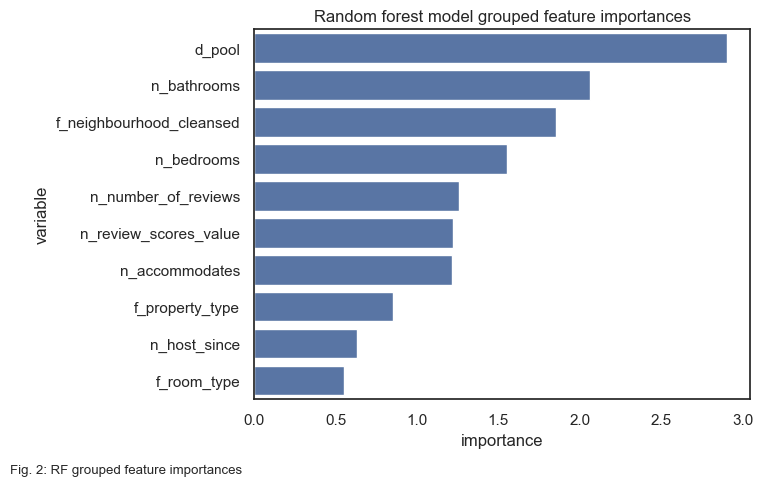

In [35]:
df_rf_grouped_var_imp = df_rf_grouped_var_imp.sort_values(by='imp', ascending=False)

sns.set(style="white")
rf_plot, ax1 = plt.subplots()
rf_fig = sns.barplot(
    data = df_rf_grouped_var_imp.iloc[0:10],
    x="imp", y="variable")
rf_fig.set(title='Random forest model grouped feature importances', xlabel="importance", ylabel="variable")
ax1.text(-1.5, 11.5, 'Fig. 2: RF grouped feature importances', size=9.5)
rf_plot.show()

In [36]:
%%time
gbm_result = permutation_importance(
    gbm_pipe,
    data_holdout[numerical_columns + categorical_columns],
    data_holdout.price,
    n_repeats=10,
    random_state=42,
    # scoring="neg_root_mean_squared_error"
)
gbm_result;

CPU times: user 42.4 s, sys: 255 ms, total: 42.6 s
Wall time: 43 s


In [37]:
df_gbm_grouped_var_imp = (pd.DataFrame(
        gbm_result.importances_mean,
        numerical_columns + categorical_columns)
                      .sort_values(by = 0, ascending = False)
                      .reset_index()
                      .rename(columns={'index': 'variable', 0: 'imp'}))
df_gbm_grouped_var_imp['cumulative_imp'] = df_gbm_grouped_var_imp.imp.cumsum()
# df_grouped_var_imp.style.format({
#     'imp': lambda x: f'{x:,.1%}',
#     'cumulative_imp': lambda x: f'{x:,.1%}'})
df_gbm_grouped_var_imp

,variable,imp,cumulative_imp
0,d_pool,3.654756,3.654756
1,f_neighbourhood_cleansed,2.980392,6.635148
2,n_bathrooms,2.385831,9.020979
3,n_number_of_reviews,1.993006,11.013985
4,n_accommodates,1.593541,12.607526
5,n_host_since,1.524565,14.132091
6,f_property_type,1.491763,15.623853
7,n_bedrooms,1.412760,17.036614
8,n_review_scores_value,1.233258,18.269872
9,f_room_type,0.889089,19.158961


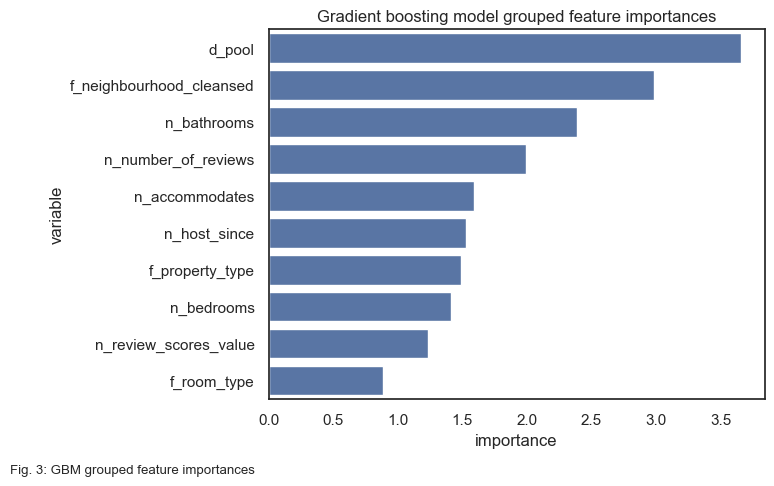

In [38]:
df_gbm_grouped_var_imp = df_gbm_grouped_var_imp.sort_values(by='imp', ascending=False)

sns.set(style="white")
gbm_plot, ax2 = plt.subplots()
gbm_fig = sns.barplot(
    data = df_gbm_grouped_var_imp.iloc[0:10],
    x="imp", y="variable")
gbm_fig.set(title='Gradient boosting model grouped feature importances', xlabel="importance", ylabel="variable")
ax2.text(-2, 11.5, 'Fig. 3: GBM grouped feature importances', size=9.5)
gbm_plot.show()

RMSE training and testing

In [54]:
def get_time_delta(delta):
    return f'{delta.seconds // 60}m{delta.seconds % 60}s'

lasso_y_holdout, lasso_X_holdout = get_lasso_matrices(lasso_data_holdout)
diagnostic_df = pd.DataFrame({'Model': ['Simple OLS', 'LASSO', 'Random Forest', 'GBM'],
                              'Train RMSE': ['{:.4f}'.format(ols_rmse), '{:.4f}'.format(lasso_search.best_score_*-1), '{:.4f}'.format(rf_random.best_score_*-1), '{:.4f}'.format(gbm_model_cv.best_score_*-1)],
                              'Holdout RMSE': ['{:.4f}'.format(mean_squared_error(ols_model.predict(ols_data_holdout.drop(columns=['price'])), ols_data_holdout['price'], squared=False)), 
                                               '{:.4f}'.format(mean_squared_error(lasso_search.predict(lasso_X_holdout), lasso_y_holdout, squared=False)), 
                                               '{:.4f}'.format(mean_squared_error(rf_pipe.predict(data_holdout[numerical_columns + categorical_columns]), data_holdout['price'], squared=False)), 
                                               '{:.4f}'.format(mean_squared_error(gbm_pipe.predict(data_holdout[numerical_columns + categorical_columns]), data_holdout['price'], squared=False))],
                              'Training time': [get_time_delta(ols_time), get_time_delta(lasso_time), get_time_delta(rf_time), get_time_delta(gbm_time)]
                              })
diagnostic_df

,Model,Train RMSE,Holdout RMSE,Training time
0,Simple OLS,44.3984,44.9380,0m0s
1,LASSO,43.9294,44.3935,5m53s
2,Random Forest,43.7054,43.4046,0m23s
3,GBM,41.2915,40.9664,7m54s


<p style="page-break-after:always;"></p>

## <center>Pricing Airbnb Apartments in Sicily, Italy</center>

### Introduction and Goal
This report investigates and explores the predictive models for forcasting Airbnb apartment prices in the top most populated and touristic cities in Sicily, Italy. The findings and models in this report will provide significant insights and help our client to price and operate small and middle size apartments hosting 2-6 guests. From the results, we will analyze and recommend the best model the client should use to price their company apartments. Since our client does not provide detailed information about the exact city and the rental purpose, this report will assume and focus on the most popular use case: leisure rentals in famous touristic cities in Sicily.

-----

### 1. Data

#### Data Preparation
The data in the report is the listing details of Sicily Airbnb apartments in March 2023 from http://insideairbnb.com/get-the-data/. Further data cleaning and filtering are applied to fit with our scope of analysis. The detailed steps are as follows:
1. Get the raw dataset (N = 51,679)
2. Apply filters (N = 16,240):
    - Drop observations with missing value in price, number of beds, number of bathrooms, apartment is instant bookable.
    - Exclude apartment type 'Hotel' as our client is not operating hotel rooms.
    - Only keep apartments accommodating for 2-6 guests.
    - Only keep apartments located in Palermo, Catania, Messina, Taormina, Realmonte, Agrigento, Siracusa, Cefal, Monreale, Ragusa and Modica.
    - Exclude some extreme price values (top 1%) by keeping observation with price <= $400.
3. Feature engineering (N = 16,240):
    - Fill 0s as values for observations with no rating values.
    - Fill 1s as values for observations with no bedrooms values as these are studios.
    - Fill 'NAN' as values for observations with no license values.
    - Create boolean values for super host, host has profile picture, host identity verified, apartment is instant bookable and host has license.
    - Convert listing duration from text to number of days before 31/03/2023.
    - Convert price from text to numerical values.
    - Derive number of bathrooms from the bathroom text descriptions.
    - Clean the property type to remove the redundant values of room type.
    - Derive various boolean variables for amenities from the amenities text descriptions.

From all the data features in the raw dataset, we will use a subset of the those as predictors with the following rationales:
- Profile photo, verification status, license and number of listings may influence price as host without those can price lower to attract guests.
- Room details (location, type of property and room, number of accommodations, bedrooms, bathrooms, reviews, amenities, instant bookable, number of allowed nights) are chosen as room with higher value in any of those features can demand higher price from intuition.
- Other features are excluded as they are presented in another predictors (like longitude) or are irrelevant to our scope.

#### Data Exploration

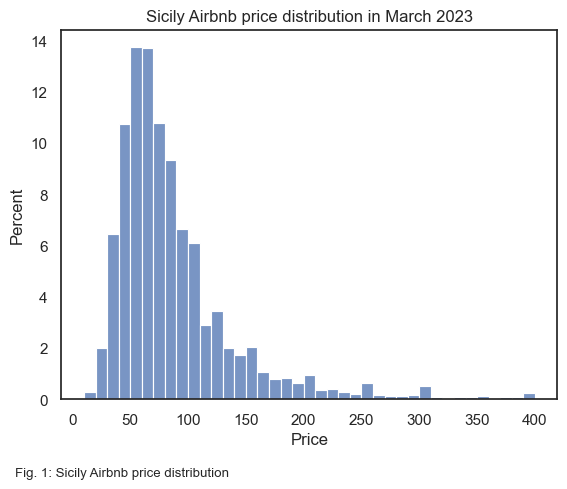

In [126]:
sns.set(style="white")
price_plot, ax3 = plt.subplots()
price_fig = sns.histplot(
    data = work_df,
    x = 'price', stat='percent', binwidth=10)
price_fig.set(title='Sicily Airbnb price distribution in March 2023', xlabel="Price")
ax3.text(-50, -3, 'Fig. 1: Sicily Airbnb price distribution', size=9.5)
price_plot.show()

From Fig. 1, it is clear that the price distribution is left-skewed. This means that the mean value price is not the typical value. Within this paper, the OLS models will assume that the mean is typical and will predict the mean value. It is worth noting that normally this is not the case and there might be impacts on the prediction results made by the OLS models.

### 2. Models